In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import re # Regular expressions

from matplotlib import pyplot as plt # image visualization

# Image manipulation
from skimage import io

import tensorflow as tf
import keras

import numpy as np

from keras.applications.vgg16 import VGG16

In [2]:
# Variable declaration
image_mode = "FLAIR" # FLAIR - T1w - T1wCE - T2w
patient_mode = "central" # central - first TODO: Explain 
input_dir = "../input/rsna-miccai-png/train" 
target_dir = "../input/rsna-miccai-png/test"

batch_size = 8
optimizer = "Adam"
learning_rate = 0.001
epochs = 3
loss_function = "binary_crossentropy"


In [3]:
# Get path to the training images
input_img_paths_patients = sorted([
    os.path.join(input_dir, fname + "/" + image_mode) 
    for fname in os.listdir(input_dir)
    if os.path.exists(os.path.join(input_dir, fname + "/" + image_mode))])

# Read images
input_img_paths = []
for patient in input_img_paths_patients:
    # TODO: Explain
    # TODO: Choosing first makes no sense. Because of the way images are taken. Center or bigger
    images_id = x = [int(re.findall(r'\d+', x)[0]) for x in os.listdir(patient)] # Get all image ids
    if patient_mode == "central":
        index_central_image = min(images_id) + round((max(images_id) - min(images_id))/2) # Get middle image
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
    if patient_mode == "first":
        index_central_image = min(images_id) # Get first image
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
            
# Read csv labels
df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

# Obtain pure labels
labels = []
for img_path in input_img_paths:
    labels.append(df.loc[df['BraTS21ID'] == int(re.findall(r'\d+', img_path)[0])]['MGMT_value'].iloc[0])

# **Data visualization**

Text(0.5, 1.0, 'Tumor presence: 0')

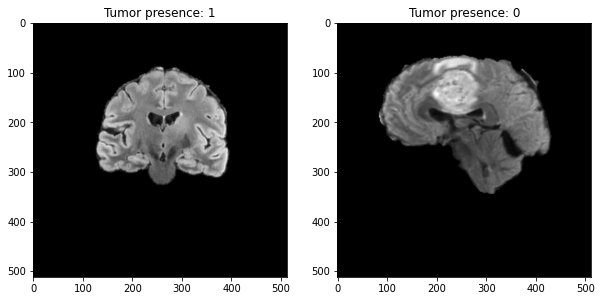

In [4]:
# Read training images and visualize
i = 0
while labels[0] == labels[i]: 
    i+=1

# Create figure
fig = plt.figure(figsize=(10, 10))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[0]), cmap='gray')
plt.title(f"Tumor presence: {labels[0]}")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(input_img_paths[i]), cmap='gray')
plt.title(f"Tumor presence: {labels[i]}")

In [5]:
# Split data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(input_img_paths, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42) # 0.111*0.9 = 0.1

# Check amounts of data in each split
print(f"Training samples: {str(len(X_train))}\nValidation samples: {str(len(X_val))}\nTest samples: {str(len(X_test))}")

# Create dataframes for keras flow_from_dataframe
data = {'id': X_train, 'label': [str(x) for x in y_train]}
train_df = pd.DataFrame(data)

data = {'id': X_val, 'label': [str(x) for x in y_val]}
val_df = pd.DataFrame(data)

data = {'id': X_test, 'label': [str(x) for x in y_test]}
test_df = pd.DataFrame(data)

Training samples: 464
Validation samples: 59
Test samples: 59


In [6]:
def load_dataset(train_df, val_df, test_df, data_augmentation=False):
    """
    This function loads the dataset from dataset folder
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """

    # Create a data generator
    if data_augmentation:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                        rotation_range=20,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        zoom_range=0.2,
                                                                        horizontal_flip=True)
    else:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
    datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Load and iterate training dataset
    train_generator=datagen_train.flow_from_dataframe(dataframe=train_df, x_col="id", y_col="label", class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate validation dataset
    val_generator=datagen_val_test.flow_from_dataframe(dataframe=val_df, x_col="id", y_col="label", class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate test dataset
    test_generator=datagen_val_test.flow_from_dataframe(dataframe=test_df, x_col="id", y_col="label", class_mode="binary", batch_size=batch_size, target_size=(224, 224))

    return train_generator, val_generator, test_generator

In [7]:
import cv2

sizes = []
for image in list(test_df['id']):
    sizes.append(np.shape(cv2.imread(image)))

for image in list(train_df['id']):
    sizes.append(np.shape(cv2.imread(image)))

for image in list(val_df['id']):
    sizes.append(np.shape(cv2.imread(image)))
    
def unique(list1):
    unique_list = []

    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    for x in unique_list:
        print(x),

unique(sizes)

(256, 256, 3)
(256, 192, 3)
(512, 512, 3)
(448, 448, 3)
(320, 320, 3)
(256, 224, 3)
(512, 416, 3)
(320, 280, 3)
(320, 260, 3)
(512, 384, 3)
(440, 440, 3)
(640, 480, 3)
(512, 448, 3)
(512, 408, 3)
(768, 768, 3)
(256, 208, 3)
(256, 204, 3)
(480, 480, 3)
(384, 312, 3)
(240, 240, 3)
(256, 216, 3)
(232, 256, 3)


In [8]:
# Load dataset
train_generator, val_generator, test_generator = load_dataset(train_df, val_df, test_df)

Found 464 validated image filenames belonging to 2 classes.
Found 59 validated image filenames belonging to 2 classes.
Found 59 validated image filenames belonging to 2 classes.


In [9]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = keras.models.Sequential()
model.add(VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet'))
#model.add(VGG16(include_top=False, input_tensor=img_conc, weights='imagenet'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

2022-12-07 20:18:09.173901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 20:18:09.277120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 20:18:09.278090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 20:18:09.280207: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 40,931,137
Trainable params: 40,931,137
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Choose optimizer
if optimizer == "SGD": # SGD
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop": # RMSprop
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else:  # Adam
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-8, amsgrad=True)

In [11]:
# Configure the model for training.
model.compile(optimizer=fit_optimizer, loss=loss_function, metrics=['accuracy'])

# Safe best model
callbacks = [keras.callbacks.ModelCheckpoint("lesion_segmentaion.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
model_history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

# Serialize and save model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize and save weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/3


2022-12-07 20:18:14.646804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-07 20:18:16.492159: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


58/58 [==============================] - 14s 94ms/step - loss: 2.2775 - accuracy: 0.4655 - val_loss: 0.6922 - val_accuracy: 0.5424
Epoch 2/3
58/58 [==============================] - 5s 79ms/step - loss: 0.6928 - accuracy: 0.5194 - val_loss: 0.6911 - val_accuracy: 0.5424
Epoch 3/3
58/58 [==============================] - 5s 78ms/step - loss: 0.6926 - accuracy: 0.5194 - val_loss: 0.6907 - val_accuracy: 0.5424
Saved model to disk


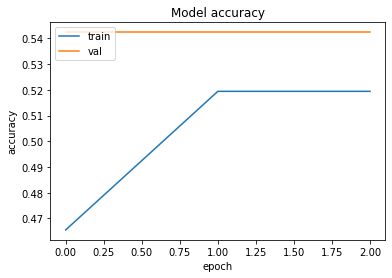

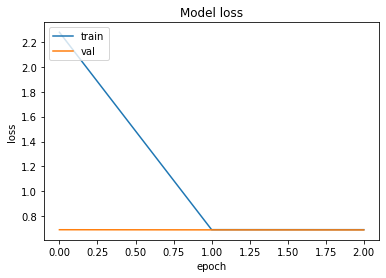

In [12]:
def create_plots(history_plot):
    """
    This functions creates the plots accuracy and loss evolution in training and validation
    :param history_plot: Record of training loss values and metrics values at successive epochs
    :return: It saves the accuracy and loss plots
    """
    # Accuracy plot
    plt.plot(history_plot.history['accuracy'])
    plt.plot(history_plot.history['val_accuracy'])
    plt.title(f'Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'MAMe_accuracy.pdf')
    plt.show()
    plt.close()

    # Loss plot
    plt.plot(history_plot.history['loss'])
    plt.plot(history_plot.history['val_loss'])
    plt.title(f'Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'MAMe_loss.pdf')
    plt.show()

create_plots(model_history)